In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("minethatdata_womens_train.csv")

In [3]:
data.head()

,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,54222,10,1) $0 - $100,29.99,0,1,Surburban,1,Phone,No E-Mail,0,0,0.0
1,30074,6,3) $200 - $350,292.39,0,1,Rural,0,Phone,Womens E-Mail,0,0,0.0
2,2725,8,1) $0 - $100,35.57,1,0,Surburban,0,Phone,No E-Mail,0,0,0.0
3,52884,1,1) $0 - $100,75.64,1,0,Surburban,1,Web,No E-Mail,0,0,0.0
4,42004,4,1) $0 - $100,29.99,1,0,Surburban,1,Web,Womens E-Mail,0,0,0.0


## 1. Сравнение групп

In [4]:
data['segment'].value_counts()

Womens E-Mail    10709
No E-Mail        10637
Name: segment, dtype: int64

In [5]:
data_trgt = data[data['segment'] == 'Womens E-Mail'].reset_index(drop=True)
data_ctrl = data[data['segment'] == 'No E-Mail'].reset_index(drop=True)

In [6]:
mean_control_list = []
mean_treated_list = []
ate_list = []
relative_change_list = []

In [7]:
mean_control_list.append(data_ctrl['visit'].mean())
mean_control_list.append(data_ctrl['conversion'].mean())
mean_control_list.append(data_ctrl['spend'].mean())

In [8]:
mean_treated_list.append(data_trgt['visit'].mean())
mean_treated_list.append(data_trgt['conversion'].mean())
mean_treated_list.append(data_trgt['spend'].mean())

In [9]:
ate_list = [i - j for i, j in zip(mean_treated_list, mean_control_list)]

In [10]:
relative_change_list = [i/j for i, j in zip(mean_treated_list, mean_control_list)]

In [11]:
df = pd.DataFrame()
df['variable'] = ['visit', 'conversion', 'spend']
df['mean_control'] = mean_control_list
df['mean_treated'] = mean_treated_list
df['ate'] = ate_list
df['relative_change'] = relative_change_list

df.to_csv('3-1-7_v0.csv', index=False)

In [12]:
df.head()

,variable,mean_control,mean_treated,ate,relative_change
0,visit,0.101720,0.148193,0.046473,1.456867
1,conversion,0.004983,0.008498,0.003515,1.705437
2,spend,0.583971,1.131093,0.547121,1.936898


## 2. Волатильность метрик

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html

In [13]:
import numpy as np
from scipy.stats import t
import numpy as np, scipy.stats as st
from tqdm import tqdm

In [14]:
def get_sample(data_trgt, data_ctrl, name='visit', n=100):
    var_list = []
    for _ in tqdm(range(n)):
        mean_treated = (1.0 * np.random.choice(np.array(data_trgt[name].tolist()), len(data_trgt), replace=True)).mean()
        mean_control = (1.0 * np.random.choice(np.array(data_ctrl[name].tolist()), len(data_ctrl), replace=True)).mean()
        var = mean_treated - mean_control
        var_list.append(var)
    return var_list

In [15]:
sample = get_sample(data_trgt, data_ctrl, name='visit', n=1000)
np.percentile(sample, 5), np.percentile(sample, 95)

100%|██████████| 1000/1000 [00:01<00:00, 522.36it/s]


(0.03863467570515822, 0.0539360347858414)

In [16]:
sample = get_sample(data_trgt, data_ctrl, name='conversion', n=1000)
np.percentile(sample, 5), np.percentile(sample, 95)

100%|██████████| 1000/1000 [00:01<00:00, 591.57it/s]


(0.001832128945074469, 0.005385665922285567)

In [17]:
sample = get_sample(data_trgt, data_ctrl, name='spend', n=1000)
np.percentile(sample, 5), np.percentile(sample, 95)

100%|██████████| 1000/1000 [00:01<00:00, 585.42it/s]


(0.25678864887311387, 0.845674364123109)

In [18]:
def get_sample_rc(data_trgt, data_ctrl, name='visit', n=100):
    var_list = []
    for _ in tqdm(range(n)):
        mean_treated = (1.0 * np.random.choice(np.array(data_trgt[name].tolist()), len(data_trgt), replace=True)).mean()
        mean_control = (1.0 * np.random.choice(np.array(data_ctrl[name].tolist()), len(data_ctrl), replace=True)).mean()
        var = mean_treated/mean_control
        var_list.append(var)
    return var_list

In [19]:
sample = get_sample_rc(data_trgt, data_ctrl, name='visit', n=1000)
np.percentile(sample, 5), np.percentile(sample, 95)

100%|██████████| 1000/1000 [00:01<00:00, 580.13it/s]


(1.3746882372088434, 1.5505380279724938)

In [20]:
sample = get_sample_rc(data_trgt, data_ctrl, name='conversion', n=1000)
np.percentile(sample, 5), np.percentile(sample, 95)

100%|██████████| 1000/1000 [00:01<00:00, 592.31it/s]


(1.318911563584483, 2.2597837049965928)

In [21]:
sample = get_sample_rc(data_trgt, data_ctrl, name='spend', n=1000)
np.percentile(sample, 5), np.percentile(sample, 95)

100%|██████████| 1000/1000 [00:01<00:00, 591.46it/s]


(1.3607711793173793, 2.8944681166099175)

## 3. Прогнозирование uplift

In [22]:
import catboost as cb
from typing import List
from sklearn.model_selection import train_test_split

In [53]:
data = pd.read_csv("minethatdata_womens_train.csv")
test = pd.read_csv("minethatdata_womens_test_no_answers.csv")

In [54]:
test.head()

,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment
0,61726,2,1) $0 - $100,74.04,0,1,Urban,0,Phone,No E-Mail
1,57540,3,4) $350 - $500,435.14,1,0,Urban,1,Multichannel,Womens E-Mail
2,58265,3,2) $100 - $200,112.96,0,1,Surburban,0,Web,Womens E-Mail
3,46218,8,1) $0 - $100,29.99,1,0,Urban,1,Phone,No E-Mail
4,60139,7,3) $200 - $350,219.81,1,0,Rural,0,Multichannel,No E-Mail


### Transform

In [25]:
def one_hot_encode(data: pd.DataFrame, cols: List[str] = None) -> pd.DataFrame:
    if cols is None:
        cols = data.columns
    result = pd.concat([data, pd.get_dummies(data[cols])], axis=1)
    return result

In [26]:
def transform_(data: pd.DataFrame) -> pd.DataFrame:
    zipcode_num_dict = {
        'Urban': 0,
        'Surburban': 1,
        'Rural': 2
    }
    data['zip_code_num'] = data['zip_code'].apply(lambda s: zipcode_num_dict[s])
    
    channel_num_dict = {
        'Web': 0,
        'Multichannel': 1,
        'Phone': 2
    }
    data['channel_num'] = data['channel'].apply(lambda s: channel_num_dict[s])
    data['history_segment_label'] = data['history_segment'].apply(lambda s: s[0])
    data = one_hot_encode(data, cols=['zip_code', 'channel', 'history_segment_label'])
    return data

In [27]:
data = transform_(data)
test = transform_(test)

In [43]:
test.head()

,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,...,channel_Multichannel,channel_Phone,channel_Web,history_segment_label_1,history_segment_label_2,history_segment_label_3,history_segment_label_4,history_segment_label_5,history_segment_label_6,history_segment_label_7
0,61726,2,1) $0 - $100,74.04,0,1,Urban,0,Phone,No E-Mail,...,0,1,0,1,0,0,0,0,0,0
1,57540,3,4) $350 - $500,435.14,1,0,Urban,1,Multichannel,Womens E-Mail,...,1,0,0,0,0,0,1,0,0,0
2,58265,3,2) $100 - $200,112.96,0,1,Surburban,0,Web,Womens E-Mail,...,0,0,1,0,1,0,0,0,0,0
3,46218,8,1) $0 - $100,29.99,1,0,Urban,1,Phone,No E-Mail,...,0,1,0,1,0,0,0,0,0,0
4,60139,7,3) $200 - $350,219.81,1,0,Rural,0,Multichannel,No E-Mail,...,1,0,0,0,0,1,0,0,0,0


In [28]:
data['treatment'] = [1 if i == 'Womens E-Mail' else 0 for i in data['segment']]

In [29]:
data.columns

Index(['index', 'recency', 'history_segment', 'history', 'mens', 'womens',
       'zip_code', 'newbie', 'channel', 'segment', 'visit', 'conversion',
       'spend', 'zip_code_num', 'channel_num', 'history_segment_label',
       'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
       'channel_Multichannel', 'channel_Phone', 'channel_Web',
       'history_segment_label_1', 'history_segment_label_2',
       'history_segment_label_3', 'history_segment_label_4',
       'history_segment_label_5', 'history_segment_label_6',
       'history_segment_label_7', 'treatment'],
      dtype='object')

### Split

In [30]:
fit_index, val_index = train_test_split(data.index, test_size=0.1, random_state=42)

### Columns

In [31]:
column_set_n1 = [
    'recency',
    'history',
    'mens',
    'womens',
    'zip_code_num',
    'channel_num'
]

In [32]:
column_set_n2 = [
    'recency',
    'mens',
    'womens',
    'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
    'channel_Multichannel', 'channel_Phone', 'channel_Web',
    'history_segment__label_1', 'history_segment__label_2',
    'history_segment__label_3', 'history_segment__label_4',
    'history_segment__label_5', 'history_segment__label_6',
    'history_segment__label_7'
]

### Modeling

In [33]:
# pip install --trusted-ho?st pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org pylift

import pylift

In [44]:
data.loc[fit_index, column_set_n1 + ['treatment', 'visit']].head()

,recency,history,mens,womens,zip_code_num,channel_num,treatment,visit
10075,12,175.68,0,1,0,2,1,0
2150,9,284.04,1,1,2,1,0,0
6909,3,397.24,1,1,0,0,1,0
4356,8,67.97,0,1,1,0,0,0
6978,2,41.24,1,0,1,2,0,0


In [34]:
upmodel_n0 = pylift.TransformedOutcome(
    data.loc[fit_index, column_set_n1 + ['treatment', 'visit']],
    col_treatment='treatment', col_outcome='visit',
    test_size=2
)

In [35]:
upmodel_n0.fit()

/Users/19587293/.local/lib/python3.8/site-packages/pylift/eval.py:474: RuntimeWarning: invalid value encountered in double_scalars
  scores['q1_qini'] = scores['Q_qini']/scores['Q_max']
/Users/19587293/.local/lib/python3.8/site-packages/pylift/eval.py:475: RuntimeWarning: invalid value encountered in double_scalars
  scores['q2_qini'] = scores['Q_qini']/scores['Q_practical_max']
/Users/19587293/.local/lib/python3.8/site-packages/pylift/eval.py:479: RuntimeWarning: invalid value encountered in double_scalars
  scores['q1_cgains'] = scores['Q_cgains']/scores['Q_max']
/Users/19587293/.local/lib/python3.8/site-packages/pylift/eval.py:480: RuntimeWarning: invalid value encountered in double_scalars
  scores['q2_cgains'] = scores['Q_cgains']/scores['Q_practical_max']
/Users/19587293/.local/lib/python3.8/site-packages/pylift/eval.py:484: RuntimeWarning: invalid value encountered in double_scalars
  scores['q1_aqini'] = scores['Q_aqini']/scores['Q_max']
/Users/19587293/.local/lib/python3.8/sit

In [36]:
eval_data = data.loc[val_index, column_set_n1 + ['treatment', 'visit']]
eval_data['score'] = upmodel_n0.model.predict(eval_data[column_set_n1])
eval_data = eval_data[['score', 'treatment', 'visit']]

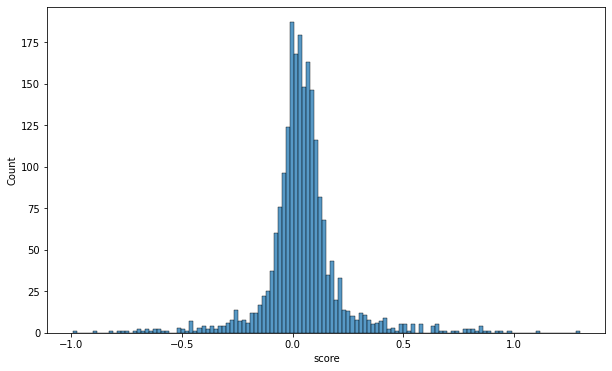

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(eval_data['score'])
plt.show()

In [48]:
test_data = test.loc[:, column_set_n1]
test_data['score'] = upmodel_n0.model.predict(test_data[column_set_n1])

In [49]:
test_data

,recency,history,mens,womens,zip_code_num,channel_num,score
0,2,74.04,0,1,0,2,-0.011630
1,3,435.14,1,0,0,1,-0.045405
2,3,112.96,0,1,1,0,0.095305
3,8,29.99,1,0,0,2,0.039941
4,7,219.81,1,0,2,1,-0.386855
...,...,...,...,...,...,...,...
21342,10,137.06,1,0,2,2,0.018665
21343,3,217.11,0,1,0,2,0.028894
21344,1,502.67,1,0,1,1,0.082508
21345,10,29.99,1,0,2,0,0.001941


In [50]:
test_data = test_data[['score']]

In [60]:
test_data['index'] = test[['index']]

<ipython-input-60-74f655787b00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['index'] = test[['index']]


In [62]:
test_data.to_csv('results3.csv', index=False)